## Assignment

In [1]:
# This is so that the jupyter notebook cells extend the full length of the display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pdb import set_trace  # for debugging purposes
import math
import matplotlib.pyplot as plt # for plots 

In [2]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [ ]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [ ]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(30):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

#     set_trace()
    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


In [ ]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



## Defining a simple Neural Network Class

In [3]:
class NeuralNetwork: 
    
    def __init__(self, init_type= 'He', layer_type = 'ReLU', optimization_alg = 'Adam', number_of_layers = 1, number_of_neurons_per_layer = [200], adam_beta = 0.9, RMSprop_beta = 0.9, output_size = 1, input_size = 58):
        """
        A function that initializes a (simple) neural network. 
        
        ----------
        Inputs:
        number_of_layers: int 
            The number of hidden layers that our network will have. 
        number_of_neurons_per_layer: list of ints of length number of layers
            neuros_per_layer[j]: The number of neurons of the j-th hidden layer. 
        layer_type: str 
            The type of activation function to use. Possible options: 'ReLU', 'sigmoid'
        optimization_alg: str
            The optimization algorithm to use for training. Possible options: 'Adam', 'RMSProp', 'GD'
        adam_beta: float 
            The beta parameter for the Adam optimization algorithm. Will only be used if Adam is used
        RMSprop_beta: float
            The beta parameter for the Adam optimization algorithm. Will only be used if Adam is used
        output_size: int 
            The output size of the Neural Network 
        input_size: int 
            The input size of the Neural Network
            
        
        """
        
        self.Ws = []
        self.bs = []
        self.layer_type = layer_type
        self.optimization_alg = optimization_alg
        
        
        
        if init_type == 'Xavier':
            W1 = np.random.randn(number_of_neurons_per_layer[0], input_size) * np.sqrt(1 / (input_size))  # first layer 
            self.Ws.append(W1)
            for i in range(1, number_of_layers):
            
                W = np.random.randn(number_of_neurons_per_layer[i], number_of_neurons_per_layer[i-1]) * np.sqrt(1 / (number_of_neurons_per_layer[i-1]))
                self.Ws.append(W)
                
            W_out = np.random.randn(output_size, number_of_neurons_per_layer[-1]) * np.sqrt(1 / (number_of_neurons_per_layer[-1]))
            self.Ws.append(W_out)
        elif init_type == 'He':
            W1 = np.random.randn(number_of_neurons_per_layer[0], input_size) * np.sqrt(2 / (input_size))  # first layer 
            self.Ws.append(W1)
            for i in range(1, number_of_layers):
                W = np.random.randn(number_of_neurons_per_layer[i], number_of_neurons_per_layer[i-1]) * np.sqrt(2 / (number_of_neurons_per_layer[i-1]))
                self.Ws.append(W)
                
            W_out = np.random.randn(output_size, number_of_neurons_per_layer[-1]) * np.sqrt(2 / (number_of_neurons_per_layer[-1]))
            self.Ws.append(W_out)
            
            
        else: 
            print('Not Implemented :=(')
            

        for i in range(number_of_layers): 
            b = np.zeros((number_of_neurons_per_layer[i],))
            self.bs.append(b)
        b_out = np.zeros((output_size,))
        self.bs.append(b_out)
#         set_trace()
        
        if (optimization_alg == 'Adam'): 
            self.Adams_per_layer = [] 
            for i in range(len(self.Ws)): 
                adam_weights = Adam(Params = self.Ws[i], beta1 = adam_beta)
                adam_biases = Adam(Params = self.bs[i], beta1=  adam_beta)
                self.Adams_per_layer.append((adam_weights, adam_biases))
        
        elif (optimization_alg == 'RMSProp'): 
            self.RMSprop_per_layer = [] 
            for i in range(len(self.Ws)): 
                RMSprop_weights = RMSProp(Params = self.Ws[i], RMS_beta = RMSprop_beta)
                RMSprop_biases = RMSProp(Params = self.bs[i], RMS_beta =  RMSprop_beta)
                self.RMSprop_per_layer.append((RMSprop_weights, RMSprop_biases))
        
        
    def forward(self, x0): 
        
        layer_out = x0
        for i in range(len(self.Ws) - 1):
            layer_out_pre_activation = np.dot(self.Ws[i], layer_out) + self.bs[i]   # calculate Wx + b
            layer_out = 1/(1+np.exp(-layer_out_pre_activation))                     # apply sigmoid function 
            
        return layer_out_pre_activation  # because the last layer should have no sigmoid! 
    
    def _forward_batch(self, x0s): 
        """
        Forwards a batch of inputs through the Neural Network, and returns both the final outputs, as well as the intermediate outputs of all layers in case they are needed for backpropagation. 
        """
        outputs = [] 
        intermediate_outputs_list = [] 
        
        for x0 in x0s:
            output, intermediate_outputs = self._forward(x0)
            
            outputs.append(output)
            intermediate_outputs_list.append(intermediate_outputs)
        
        return outputs, intermediate_outputs_list
            
            
    
    
    def _forward(self, x0): 
        
        intermediate_outputs = [] 
        layer_out = x0
        intermediate_outputs.append(layer_out)
        
        if self.layer_type == 'ReLU': 
            for i in range(len(self.Ws) - 1):
                layer_out_pre_activation = np.dot(self.Ws[i], layer_out) + self.bs[i]   # calculate Wx + b
                layer_out = layer_out_pre_activation.copy()
                layer_out[layer_out< 0] = 0    # for ReLU: make all positions <0 equal to 0
                intermediate_outputs.append(layer_out)
                
            layer_out = np.dot(self.Ws[-1], layer_out) + self.bs[-1]
            intermediate_outputs.append(layer_out)
            
            return layer_out, intermediate_outputs
                
                
            
        else: 
            print('entering sigmoid part of forward')

            for i in range(len(self.Ws) - 1):
                layer_out_pre_activation = np.dot(self.Ws[i], layer_out) + self.bs[i]   # calculate Wx + b
                layer_out = 1/(1+np.exp(-layer_out_pre_activation))                     # apply sigmoid function
                intermediate_outputs.append(layer_out)

            layer_out = np.dot(self.Ws[-1], layer_out) + self.bs[-1]
            intermediate_outputs.append(layer_out)
            
            return layer_out, intermediate_outputs
    
    
    def backward(self, x0s, outputs, desired_outputs, intermediate_outputs_list): 
        """
        The function that performs backpropagation. 
        """
        
        
        dWs = [np.zeros(shape = self.Ws[i].shape) for i in range(len(self.Ws))]
        dbiases = [np.zeros(shape = self.bs[i].shape) for i in range(len(self.bs))]  
        
        
        
        for j in range(len(x0s)): 
            
            output = outputs[j]
            desired_output = desired_outputs[j]
            intermediate_outputs = intermediate_outputs_list[j]
            x0 = x0s[j]
            
            
            error_signal = desired_output - output

            if self.layer_type == 'ReLU': 
                
                for i in reversed(range(len(self.Ws))):
                    if i == len(self.Ws) - 1:
                        delta = error_signal                  # error signal -> L,  delta x input at layer-> Derivative at that layer    :=>    dW = derivative * lr 
                        
                    else: 
                        intermediate_outputs_copy = intermediate_outputs[i+1].copy()
                        intermediate_outputs_copy[intermediate_outputs_copy < 0] = 0 
                        intermediate_outputs_copy[intermediate_outputs_copy > 0 ] = 1
                        
                        delta = intermediate_outputs_copy * error_signal
                    
#                     set_trace()
                    
                    dWs[i] = dWs[i] +  np.outer(delta, intermediate_outputs[i])
                    dbiases[i] = dbiases[i] + delta
                    
                    error_signal = np.dot(self.Ws[i].T, delta)     
            
            else: 
                print('backward entering sigmoid part!')
            
                for i in reversed(range(len(self.Ws))):

                    if i == len(self.Ws) - 1:
    #                     print('last layer!')
                        delta = error_signal
                    else:
                        delta = intermediate_outputs[i+1]*(1-intermediate_outputs[i+1]) * error_signal

                    dWs[i] = dWs[i] +  np.outer(delta, intermediate_outputs[i])
                    dbiases[i] = dbiases[i] + delta

                    error_signal = np.dot(self.Ws[i].T, delta)
                
        return dWs, dbiases
    
    def update(self, dWs, dbiases, batch_size, lr): 
        
        for i in range(len(self.Ws)): 
            self.Ws[i] = self.Ws[i] + (dWs[i] * lr) / batch_size #- (self.Ws[i] * 0.01* lr) / batch_size
            self.bs[i] = self.bs[i] + (dbiases[i] * lr) / batch_size
            
            
        
    def train(self, x_train, y_train, lr, epochs, batch_size, print_frequency = 10,  shuffle_indexes = True, return_dWs = False):
        
        number_of_batches = int(math.floor(len(x_train)/batch_size))  
        
        for i in range(epochs):    # for every epoch:
            
            if shuffle_indexes:      # if we have to, shuffle the indexes 
                shuffled_idxs = np.random.permutation(x_train.shape[0])
            else: 
                shuffled_idxs = np.array([i for i in range(len(x_train))])
                
                
            for batch in range(0, number_of_batches):   # for every batch:
                
                idxs_current_batch = shuffled_idxs[batch * batch_size : (batch + 1) * batch_size]  # get batch size number of samples

                X_batch = x_train[idxs_current_batch]
                y_batch = y_train[idxs_current_batch]


                outputs, intermediate_outputs_list =  self._forward_batch(x0s= X_batch )   # forward them through the Network 
                dWs, dbiases = self.backward(x0s = X_batch, outputs = outputs, desired_outputs = y_batch,intermediate_outputs_list = intermediate_outputs_list)  # Calculate the dWs, dbiases that would correspond to simple Gradient Descent 
                                                                                                                                                                 # for that batch 
                
                if self.optimization_alg == 'Adam': # if the Adam optimizer is used: pass the dWs, dbiases, through Adam to calculate the final values for them. 
                    dWs_adam = [] 
                    dbiases_adam = [] 
                    for k in range(len(self.Ws)):    
                        dWs_adam.append(self.Adams_per_layer[k][0].Compute(dWs[k]))
                        dbiases_adam.append(self.Adams_per_layer[k][1].Compute(dbiases[k]))
                        
                    dWs = dWs_adam
                    dbiases = dbiases_adam
                
                elif self.optimization_alg == 'RMSProp': # if RMS prop is used: pass the dWs, dbiases through RMSprop to calculate the final values for them
                    dWs_RMSprop = [] 
                    dbiases_RMSprop = [] 
                    for k in range(len(self.Ws)): 
                        dWs_RMSprop.append(self.RMSprop_per_layer[k][0].Compute(dWs[k]))
                        dbiases_RMSprop.append(self.RMSprop_per_layer[k][1].Compute(dbiases[k]))
                        
                    dWs = dWs_RMSprop
                    dbiases = dbiases_RMSprop
                        

                self.update(dWs, dbiases, batch_size, lr)   # update the parameters of the NN based on the dWs, dbiases you calculated + the batch size  and learning rate
                
                if return_dWs: 
                    return dWs
                
  

In [8]:
class Adam:
    """
    The adam optimizer, exactly as defined in the Labs of this course. 
    """

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
#         set_trace()
        print(f'Init adam was called with parameter shape: {Params.shape}')
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
        
        # Compute the Adam updates by following the scheme above (beginning of the notebook)
        
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

## Implementing RMSProp (Part of subtask 7)

In [41]:
class RMSProp:

    def __init__(self, Params, RMS_beta = 0.9):
        """
        A class implementing the RMSProp algorithm, very similar to the one given to us for Adam. 
        """
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]            
            self.gs = np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
            self.gs=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF RMSProp
        self.beta= RMS_beta
        self.epsilon=10**(-8)
        
    def Compute(self,Grads):
        
        # Compute the RMS updates by following the scheme above (beginning of the notebook)
        
        
        self.gs=self.beta*self.gs + (1-self.beta)* (Grads**2)
        
        
        New_grads= Grads / (np.sqrt(self.gs) + self.epsilon)
        
        return New_grads

## Q learning with value approximation (main code for task 3)

In [9]:
def EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon):
    """
    Plays the epsilon greedy policy, but only over the allowed_actions
    """
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:

        a=np.random.randint(0,N_a)
        
        # find the indexes of the allowed_actions 
        indexes_allowed_actions = np.where(allowed_a > 0)[0]
        # choose an action at random, but only from them! 
        a = np.random.choice(indexes_allowed_actions)

    else:
        Qvalues_copy = Qvalues.copy()
        # ensure that the non-allowed actions aren't played by making them smaller than the max
#         set_trace()
        Qvalues_copy[allowed_a == 0] = np.min(Qvalues) - 5
        
        a=np.argmax(Qvalues_copy)
            
    return a

In [ ]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [ ]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(f'Episode number: {n}')            ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING.  - Glad to hear.
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            
            break
        
        
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## ONLY TO PUT SUMETHING
            PIPPO=1
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    

In [ ]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [54]:
def Qlearning(N_episodes = 100000, number_of_layers = 1,number_of_neurons_per_layer = [200],size_board = 4, epsilon_0 = 0.2, beta = 0.00005, gamma = 0.85, eta = 0.0035, 
            custom_reward = False, opponent_king_blocked_moves_reward = 0.2, stalemate_punishment = 0, optimization_alg = 'Adam', optimizer_beta = 0.9, return_avg_derivatives = False, 
             return_dWs = False):
    
    """
    The main function that applies the Q learning algorithm (with function approximation using a Neural Network) to the chess problem of the assignment. For all of its hyperparameters, has the default values given to us in the task. 
    
    
    ---------
    Inputs: 
    N_episodes: int 
        The number of episodes to run Q learning for 
    number_of_layers: int 
        The number of hidden layers of the NN that we will use for function approximation 
    number_of_neurons_per_layer: list of ints of size number of layers 
        number_of_neuros_per_layer[j]: The number of neuros in the j-th hidden layer
    size_board: int 
        The board size of the chess environment we will create
    epsilon_0: float 
        Starting value of epsilon for the epsilon greedy policy
    beta: float 
        The parameter sets how quickly the value of epsilon is decaying. 
    gamma: float 
        The discount of feature rewards factor 
    eta: float 
        The learning rate 
    custom_reward: Bool 
        If true: Qlearning will use our own custom reward that we built for task 6 
    threatened_king_reward: float 
        The reward that the agent receives, at every non-terminal move, if it threatens the king. Only used for our custom reward. 
    opponent_king_blocked_moves_reward: float 
        The maximum possible reward that an agent can receive for blocking the opponent king's moves. Only used for our custom reward. 
    optimization_alg: str 
        The optimization algorithm to be used for the training of the Neural Network. Possible options: 'Adam', 'RMSProp', 'GD'
    optimizer_beta: float 
        The beta hyperparameter of the optimization algorithm. Only used by Adam and RMSProp. 
    return_dWs: bool 
        If true: Will also return the avg of the dWs of the Neural network per episode. used for task 7
        
        
    ---------
    Outputs: 
    R_save: numpy array of shape  (number of episodes, 1)
        R_save[j]: The reward that our agent received at the j-th episode.
    N_moves_save: numpy array of shape (number of episodes, 1)
        N_moves_save[j]: The number of moves that the j-th game needed in order to finish
    Q_nn: instance of our Neural Network class 
        The final, trained Neural Network once the specified number of episodes has finished. 
    """

    env=Chess_Env(size_board)
    
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    S,X,allowed_a=env.Initialise_game()  
    number_possible_actions=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
    input_size=np.shape(X)[0]  + number_possible_actions  ## INPUT SIZE: the feature vector + a 1-hot encoding of the 32 actions
    
    all_dWs_sum = []
    all_dWs_max = [] 

    # line 1 of Q learning (initialize Qhat)
    Q_nn = NeuralNetwork(input_size= input_size, number_of_layers= number_of_layers, number_of_neurons_per_layer= number_of_neurons_per_layer, optimization_alg = optimization_alg, adam_beta = optimizer_beta, RMSprop_beta= beta, 
                         output_size= 1, init_type= 'He')
    
    for n in range(N_episodes):
        dWs_current_episode_max = []
        dWs_current_episode_sum = []
        
        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
        if (n % 20 == 0):
            print(f'Episode number: {n}')            ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING.  - Glad to hear.

        while Done==0:                           ## START THE EPISODE

            ######
            # calculate Qhat for all possible actions
            q_hat_predictions = [] 
            for k in range(number_possible_actions):
                action_vector = [0 for j in range(number_possible_actions)]
                action_vector[k] = 1
                
                nn_input = np.append(X, action_vector)
                q_hat_action, _  = Q_nn._forward(nn_input)
                
                q_hat_predictions.append(q_hat_action)
                
            
            q_hat_predictions = np.array(q_hat_predictions)  # qhat now contains the NN prediction for all possible actions (both allowed and not) at the current state
            
            
            # Choose A from S using policy derived from Q 
            selected_action = EpsilonGreedy_Policy(Qvalues = q_hat_predictions, allowed_a = allowed_a, epsilon = epsilon_f)  
            
            action_vector = [0 for j in range(number_possible_actions)]
            action_vector[selected_action] = 1
            X_train = [np.append(X, action_vector)]
            X_train = np.array(X_train)                
            
            # Take the selected action 
            S_next,X_next,allowed_a_next,R,Done=env.OneStep(selected_action)    # progress the episode by 1 step by playing the action selected by epsilon-greedy, based on the NN predictions. 
            
            
            if not Done:
                # calculate max_a Qhat(S', a)
                q_hat_predictions = [] 
                for k in range(number_possible_actions):
                    action_vector = [0 for j in range(number_possible_actions)]
                    action_vector[k] = 1

                    nn_input = np.append(X_next, action_vector)
                    q_hat_action, _  = Q_nn._forward(nn_input)

                    q_hat_predictions.append(q_hat_action)  

                q_hat_predictions = np.array(q_hat_predictions)  # qhat now contains the NN prediction for all possible actions (both allowed and not) at state S'

                Q_star_next = q_hat_predictions[EpsilonGreedy_Policy(q_hat_predictions, allowed_a= allowed_a_next, epsilon = 0)]  # find the max Q of state S'
            
            if Done == 1:    # if the episode is done: the Q(S, action_played) should be exactly equal to the reward that was received by playing that action (unless we are using our custom reward)
                if (not custom_reward) or (env.check > 0): 
                    label = R
                else: 
                    label = R - stalemate_punishment  # we are using our custom_reward function and the game resulted in a stalemate -> add our custom negative reward to the final Q(S,a) pair. 
            else:
                if not custom_reward:                 # if the episode is not done, then calculate the loss as if the correct Q at that position was (Reward received + discount factor * Predicted Q value at next state S')
                    label = R + gamma * Q_star_next
                else: 
                    # our custom reward is the default + the extra terms that we add to it: Some constant * <whether the opponent king is checked or not> and a second constant / <the number of moves available ot the opponent king>
                    label = R  + (opponent_king_blocked_moves_reward / (1 + np.sum(env.dfk2_constrain).astype(int))) + gamma * Q_star_next
            
            # update the parameters of the network
            y_train = np.array([label])    
            if  not return_dWs:
                Q_nn.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100,  shuffle_indexes = False)
            # perform one gradient update, as described in the Q learning algorithm, by Berto and al.
            
            else: # we need to save the avg of the episode gradients 
                current_dWs = Q_nn.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100,  shuffle_indexes = False, return_dWs= True)
                
                flattened_dWs_list = [array.flatten() for array in current_dWs]    # make the list of all dWs one dimensional
                merged_list = [item for sublist in flattened_dWs_list for item in sublist]
                sum_abs_dW = np.abs(merged_list).sum()                              # calculate the max/sum of all the dWs of the episode
                max_abs_dW = np.abs(merged_list).max()
                dWs_current_episode_max.append(max_abs_dW)                                         # save it on the episode list 
                dWs_current_episode_sum.append(sum_abs_dW)
            
            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                R_save[n] = R
                N_moves_save[n] = i
                
                if return_dWs: 
                    all_dWs_max.append(np.mean(dWs_current_episode_max))
                    all_dWs_sum.append(np.mean(dWs_current_episode_sum))
    
                break

            # IF THE EPISODE IS NOT OVER...
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

    if not return_dWs:
        return R_save, N_moves_save, Q_nn
    else: 
        return R_save, N_moves_save, Q_nn, np.array(all_dWs_sum), np.array(all_dWs_max)



In [45]:
 R_save, N_moves_save, Q_nn, all_dWs_sum, all_dWs_max = Qlearning(N_episodes= 2000 ,return_dWs= True)

Before defining the network
Init adam was called with parameter shape: (200, 90)
Init adam was called with parameter shape: (200,)
Init adam was called with parameter shape: (1, 200)
Init adam was called with parameter shape: (1,)
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800


In [47]:
all_dWs_max

array([0.64260416, 0.70113194, 1.10416747, ..., 2.85254515, 2.83063195,
       3.06379035])

In [38]:
 R_save, N_moves_save, Q_nn, all_dWs_GD = Qlearning(N_episodes= 2000, optimization_alg= 'GD', return_dWs= True,)

Before defining the network
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800


In [42]:
 R_save, N_moves_save, Q_nn, all_dWs_RMS = Qlearning(N_episodes= 2000, optimization_alg= 'RMSProp', return_dWs= True,)

Before defining the network
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800


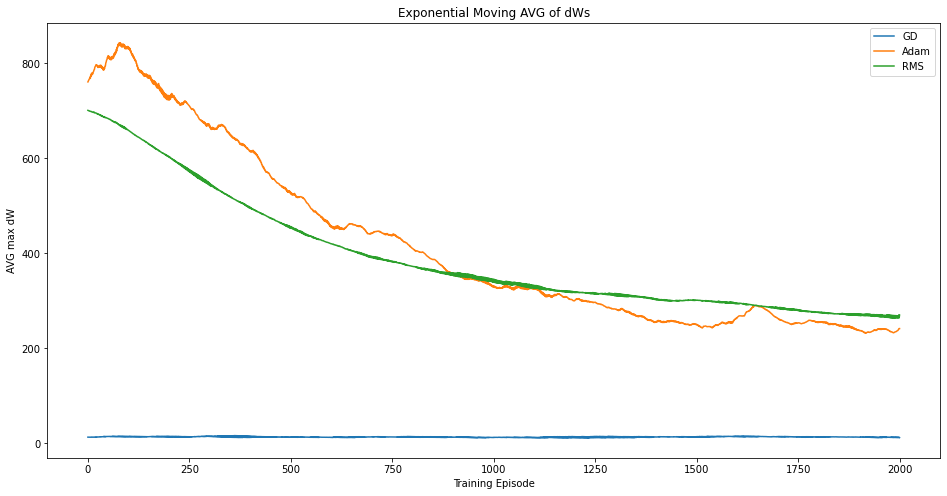

In [43]:
plot_exponential_moving_avgs([all_dWs_GD ,all_dWs, all_dWs_RMS], plot_labels=  ['GD', 'Adam', 'RMS'], y_label = 'AVG max dW', title = 'Exponential Moving AVG of dWs')

### Defining the function to plot all our results 

In [28]:
def exponential_moving_average(x, smoothing_parameter=0.99):
    initial_value = 0
    x_ema = [x[0]]
    
    for i in range(len(x)):
        x_ema.append(x_ema[i-1]*(smoothing_parameter) + x[i]*(1-smoothing_parameter))
                        
    return x_ema[1:]

In [29]:
def plot_exponential_moving_avgs(result_arrays, plot_labels = ['Qlearning'], y_label = 'Reward',title = 'Exponential Moving Average of Reward Per Game', alpha = 1):
    """
    A custom function that takes as input a list of numpy arrays, each of whom has the same shape as returned by different runs of our Q-learning/ Double Q-learning implementations, 
    and plots all of the corresponding exponential moving averages. 
    """
    
    
    plt.figure(figsize=(16,8))
    
    for (j, result_array) in enumerate(result_arrays):
        result_array_copy = result_array.copy()

        R_list = list(result_array_copy.flatten())
        R_list_ema = exponential_moving_average(R_list)

        plt.plot(R_list_ema, label = plot_labels[j], alpha = alpha)
        
        
    plt.xlabel("Training Episode")
    plt.ylabel(y_label)
         
    plt.title(title)
    plt.legend()
    plt.show()

## Plotting the performance of "vanilla" Q learning with function approximation (task 3)

In [ ]:
R_save_GD, N_moves_save_GD, Q_nn_GD = Qlearning(optimization_alg= 'GD')

In [ ]:
plot_exponential_moving_avgs([R_save_GD], plot_labels= [''], 
                             title = 'Trying Q learning with GD on our problem - Exponential Moving AVG of reward per game')

In [ ]:
plot_exponential_moving_avgs([N_moves_save_GD], plot_labels= [''], 
                             title = 'Trying Q learning with GD on our problem - Exponential Moving AVG of game duration', y_label = '# of Moves')

## Testing how chaning $\gamma$ and $\beta$ affects the results (subtask 4)

In [ ]:
gamma_rewards = [] 
gamma_moves = [] 

for gamma in [0.99, 0.95, 0.9, 0.85, 0.75, 0.65, 0.5]: 
    print(f'Current gamma: {gamma}')
    R_save, N_moves_save, Q_nn = Qlearning(N_episodes= 60000, gamma = gamma, optimization_alg=  'GD')
    gamma_rewards.append(R_save)
    gamma_moves.append(N_moves_save)
    

In [ ]:
plot_exponential_moving_avgs(gamma_rewards, plot_labels= [0.99, 0.95, 0.9, 0.85, 0.75, 0.65, 0.5], 
                             title = 'Testing how different gamma values affect training - Exponential Moving AVG of reward per game', alpha = 0.75)

In [ ]:
plot_exponential_moving_avgs(gamma_moves, plot_labels= [0.99, 0.95, 0.9, 0.85, 0.75, 0.65, 0.5], 
                             title = 'Testing how different gamma values affect training - Exponential Moving AVG of game duration', y_label= '# of moves', alpha = 0.75)

In [ ]:
beta_rewards = [] 
beta_moves = [] 

for beta in [5e-7 ,5e-6 ,5e-5, 5e-4, 5e-3]: 
    print(f'Current beta: {beta}')
    R_save, N_moves_save, Q_nn = Qlearning(N_episodes= 20000, beta= beta, optimization_alg=  'GD')
    beta_rewards.append(R_save)
    beta_moves.append(N_moves_save)

In [ ]:
plot_exponential_moving_avgs(beta_rewards, plot_labels= [5e-7 ,5e-6 ,5e-5, 5e-4, 5e-3], 
                             title = 'Testing how different beta values affect training (gamma constant to 0.85)- Exponential Moving AVG of reward per game')

In [ ]:
plot_exponential_moving_avgs(beta_moves, plot_labels= [5e-7 ,5e-6 ,5e-5, 5e-4, 5e-3], 
                             title = 'Testing how different beta values affect training (gamma constant to 0.85)- Exponential Moving AVG of game duration', y_label = '# of moves')

## Testing our custom reward (subtask 6)

In [ ]:
R_save_custom_R, N_moves_save_custom_R, Q_nn_custom_R = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0, opponent_king_blocked_moves_reward= 0.1)

In [ ]:
R_save_custom_R2, N_moves_save_custom_R2, Q_nn_custom_R2 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0, opponent_king_blocked_moves_reward= 0.05)

In [ ]:
R_save_custom_R3, N_moves_save_custom_R3, Q_nn_custom_R3 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0, opponent_king_blocked_moves_reward= 0.2)

In [ ]:
R_save_custom_R4, N_moves_save_custom_R4, Q_nn_custom_R4 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0, opponent_king_blocked_moves_reward= 0.15)

In [ ]:
R_save_custom_RK1, N_moves_save_custom_RK1, Q_nn_custom_RK1 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0.05, opponent_king_blocked_moves_reward= 0)
R_save_custom_RK2, N_moves_save_custom_RK2, Q_nn_custom_RK2 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0.1, opponent_king_blocked_moves_reward= 0)

In [ ]:
R_save_custom_RK3, N_moves_save_custom_RK3, Q_nn_custom_RK3 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0.15, opponent_king_blocked_moves_reward= 0)
R_save_custom_RK4, N_moves_save_custom_RK4, Q_nn_custom_RK4 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0.2, opponent_king_blocked_moves_reward= 0)

In [ ]:
R_save_custom_RK5, N_moves_save_custom_RK5, Q_nn_custom_RK5 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0.25, opponent_king_blocked_moves_reward= 0)
R_save_custom_RK6, N_moves_save_custom_RK6, Q_nn_custom_RK6 = Qlearning(N_episodes= 10000, custom_reward= True, threatened_king_reward= 0.3, opponent_king_blocked_moves_reward= 0)

In [ ]:
R_save_custom_RS0, N_moves_save_custom_RS0, Q_nn_custom_RS0 = Qlearning(N_episodes= 10000, custom_reward= True, opponent_king_blocked_moves_reward= 0, stalemate_punishment= 0)
R_save_custom_RS1, N_moves_save_custom_RS1, Q_nn_custom_RS1 = Qlearning(N_episodes= 10000, custom_reward= True, opponent_king_blocked_moves_reward= 0, stalemate_punishment= 0.1)
R_save_custom_RS2, N_moves_save_custom_RS2, Q_nn_custom_RS2 = Qlearning(N_episodes= 10000, custom_reward= True, opponent_king_blocked_moves_reward= 0, stalemate_punishment= 0.2)

In [ ]:
R_save_custom_RS4, N_moves_save_custom_RS4, Q_nn_custom_RS4 = Qlearning(N_episodes= 10000, custom_reward= True, opponent_king_blocked_moves_reward= 0, stalemate_punishment= 0.3)
R_save_custom_RS5, N_moves_save_custom_RS5, Q_nn_custom_RS5 = Qlearning(N_episodes= 10000, custom_reward= True, opponent_king_blocked_moves_reward= 0, stalemate_punishment= 0.4)
R_save_custom_RS6, N_moves_save_custom_RS6, Q_nn_custom_RS6 = Qlearning(N_episodes= 10000, custom_reward= True, opponent_king_blocked_moves_reward= 0, stalemate_punishment= 0.5)

In [ ]:
plot_exponential_moving_avgs([R_save_custom_RS0 ,R_save_custom_RS1, R_save_custom_RS2, R_save_custom_RS4, R_save_custom_RS5, R_save_custom_RS6], plot_labels= [ '0.0','0.1', '0.2', '0.3', '0.4','0.5' ], 
                             title = 'Adding a negative reward for stalemating - Exponential Moving AVG of reward per game')

In [ ]:
plot_exponential_moving_avgs([N_moves_save_custom_RS0 ,N_moves_save_custom_RS1, N_moves_save_custom_RS2, N_moves_save_custom_RS4, N_moves_save_custom_RS5, N_moves_save_custom_RS6], plot_labels= [ '0.0','0.1', '0.2', '0.3', '0.4','0.5' ], 
                             title = 'Adding a negative reward for stalemating - Exponential Moving AVG of game duration', y_label = '# of Moves')

In [ ]:
R_save_custom_RC1, N_moves_save_custom_RC1, Q_nn_custom_RC1 = Qlearning(N_episodes= 10000, custom_reward= True, stalemate_punishment= 1, opponent_king_blocked_moves_reward= 0.15 )

In [ ]:
R_save_custom_RC2, N_moves_save_custom_RC2, Q_nn_custom_RC2 = Qlearning(N_episodes= 10000, custom_reward= True, stalemate_punishment= 1, opponent_king_blocked_moves_reward= 0.3 )

In [ ]:
R_save_custom_RC3, N_moves_save_custom_RC3, Q_nn_custom_RC3 = Qlearning(N_episodes= 10000, custom_reward= True, stalemate_punishment= 1, opponent_king_blocked_moves_reward= 0.075 )
R_save_custom_RC4, N_moves_save_custom_RC4, Q_nn_custom_RC4 = Qlearning(N_episodes= 10000, custom_reward= True, stalemate_punishment= 1, opponent_king_blocked_moves_reward= 0.225 )

In [ ]:
plot_exponential_moving_avgs([R_save_custom_RS0 ,R_save_custom_RC1, R_save_custom_RC2, R_save_custom_RC3, R_save_custom_RC4], plot_labels= ['0, 0','1, 0.15', '1, 0.3', '1, 0.075', '1, 0.225'], 
                             title = 'Combining both components of our custom reward - Exponential Moving AVG of reward per game')

In [ ]:
plot_exponential_moving_avgs([N_moves_save_custom_RS0 ,N_moves_save_custom_RC1, N_moves_save_custom_RC2, N_moves_save_custom_RC3, N_moves_save_custom_RC4], plot_labels= ['0, 0','1, 0.15', '1, 0.3', '1, 0.075', '1, 0.225'], 
                             title = 'Combining both components of our custom reward - Exponential Moving AVG of game duration', y_label = '# of Moves')

### Testing RMSProp vs GD and Adam (Subtask 7)

In [48]:
optimizer_rewards = [] 
optimizer_moves = [] 
optimizer_max_dWs = [] 
optimizer_sum_dWs = [] 


for optimization_alg in ['Adam', 'RMSProp', 'GD']:
    print(f'Current optimizer: {optimization_alg}')
    R_save, N_moves_save, Q_nn, all_dWs_sum, all_dWs_max = Qlearning(N_episodes= 100000 ,return_dWs= True, optimization_alg= optimization_alg)
    optimizer_rewards.append(R_save)
    optimizer_moves.append(N_moves_save)
    optimizer_max_dWs.append(all_dWs_max)
    optimizer_sum_dWs.append(all_dWs_sum)

Current optimizer: Adam
Before defining the network
Init adam was called with parameter shape: (200, 90)
Init adam was called with parameter shape: (200,)
Init adam was called with parameter shape: (1, 200)
Init adam was called with parameter shape: (1,)
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800
Episode number: 2000
Episode number: 2200
Episode number: 2400
Episode number: 2600
Episode number: 2800
Episode number: 3000
Episode number: 3200
Episode number: 3400
Episode number: 3600
Episode number: 3800
Episode number: 4000
Episode number: 4200
Episode number: 4400
Episode number: 4600
Episode number: 4800
Episode number: 5000
Episode number: 5200
Episode number: 5400
Episode number: 5600
Episode number: 5800
Episode number: 6000
Episode number: 6200
Episode number: 6400
Episode number: 6600
Episode number: 6800

Episode number: 72600
Episode number: 72800
Episode number: 73000
Episode number: 73200
Episode number: 73400
Episode number: 73600
Episode number: 73800
Episode number: 74000
Episode number: 74200
Episode number: 74400
Episode number: 74600
Episode number: 74800
Episode number: 75000
Episode number: 75200
Episode number: 75400
Episode number: 75600
Episode number: 75800
Episode number: 76000
Episode number: 76200
Episode number: 76400
Episode number: 76600
Episode number: 76800
Episode number: 77000
Episode number: 77200
Episode number: 77400
Episode number: 77600
Episode number: 77800
Episode number: 78000
Episode number: 78200
Episode number: 78400
Episode number: 78600
Episode number: 78800
Episode number: 79000
Episode number: 79200
Episode number: 79400
Episode number: 79600
Episode number: 79800
Episode number: 80000
Episode number: 80200
Episode number: 80400
Episode number: 80600
Episode number: 80800
Episode number: 81000
Episode number: 81200
Episode number: 81400
Episode nu

Episode number: 47000
Episode number: 47200
Episode number: 47400
Episode number: 47600
Episode number: 47800
Episode number: 48000
Episode number: 48200
Episode number: 48400
Episode number: 48600
Episode number: 48800
Episode number: 49000
Episode number: 49200
Episode number: 49400
Episode number: 49600
Episode number: 49800
Episode number: 50000
Episode number: 50200
Episode number: 50400
Episode number: 50600
Episode number: 50800
Episode number: 51000
Episode number: 51200
Episode number: 51400
Episode number: 51600
Episode number: 51800
Episode number: 52000
Episode number: 52200
Episode number: 52400
Episode number: 52600
Episode number: 52800
Episode number: 53000
Episode number: 53200
Episode number: 53400
Episode number: 53600
Episode number: 53800
Episode number: 54000
Episode number: 54200
Episode number: 54400
Episode number: 54600
Episode number: 54800
Episode number: 55000
Episode number: 55200
Episode number: 55400
Episode number: 55600
Episode number: 55800
Episode nu

Episode number: 21400
Episode number: 21600
Episode number: 21800
Episode number: 22000
Episode number: 22200
Episode number: 22400
Episode number: 22600
Episode number: 22800
Episode number: 23000
Episode number: 23200
Episode number: 23400
Episode number: 23600
Episode number: 23800
Episode number: 24000
Episode number: 24200
Episode number: 24400
Episode number: 24600
Episode number: 24800
Episode number: 25000
Episode number: 25200
Episode number: 25400
Episode number: 25600
Episode number: 25800
Episode number: 26000
Episode number: 26200
Episode number: 26400
Episode number: 26600
Episode number: 26800
Episode number: 27000
Episode number: 27200
Episode number: 27400
Episode number: 27600
Episode number: 27800
Episode number: 28000
Episode number: 28200
Episode number: 28400
Episode number: 28600
Episode number: 28800
Episode number: 29000
Episode number: 29200
Episode number: 29400
Episode number: 29600
Episode number: 29800
Episode number: 30000
Episode number: 30200
Episode nu

Episode number: 96000
Episode number: 96200
Episode number: 96400
Episode number: 96600
Episode number: 96800
Episode number: 97000
Episode number: 97200
Episode number: 97400
Episode number: 97600
Episode number: 97800
Episode number: 98000
Episode number: 98200
Episode number: 98400
Episode number: 98600
Episode number: 98800
Episode number: 99000
Episode number: 99200
Episode number: 99400
Episode number: 99600
Episode number: 99800


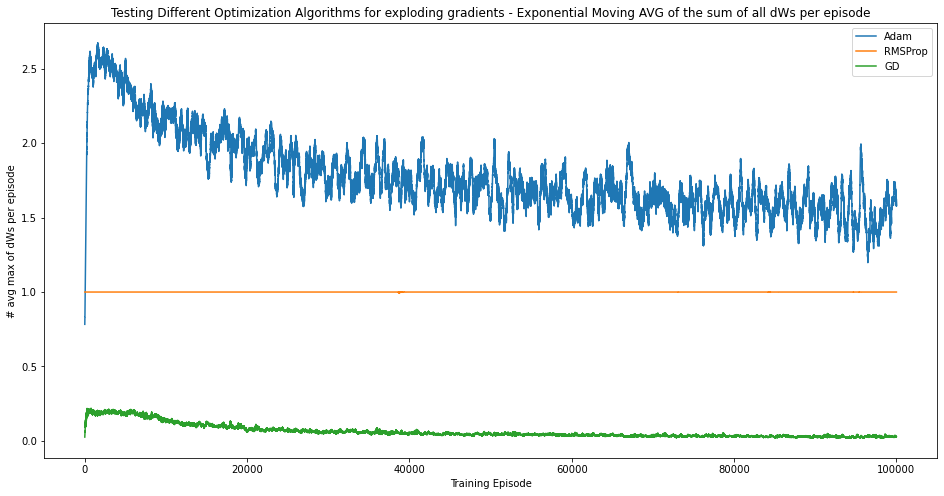

In [49]:
plot_exponential_moving_avgs(optimizer_max_dWs, plot_labels= ['Adam', 'RMSProp', 'GD'], 
                             title = 'Testing Different Optimization Algorithms for exploding gradients - Exponential Moving AVG of the sum of all dWs per episode', y_label = '# avg max of dWs per episode')

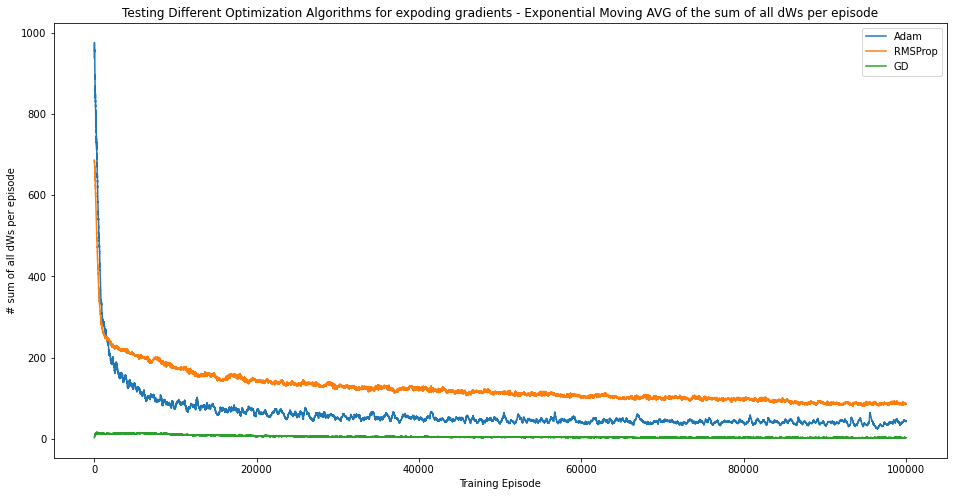

In [50]:
plot_exponential_moving_avgs(optimizer_sum_dWs, plot_labels= ['Adam', 'RMSProp', 'GD'], 
                             title = 'Testing Different Optimization Algorithms for expoding gradients - Exponential Moving AVG of the sum of all dWs per episode', y_label = '# sum of all dWs per episode')

In [ ]:
optimizer_rewards_bignn = [] 
optimizer_moves_bignn = [] 
optimizer_max_dWs_bignn = [] 
optimizer_sum_dWs_bignn = [] 


for optimization_alg in ['GD']:
    print(f'Current optimizer: {optimization_alg}')
    R_save, N_moves_save, Q_nn, all_dWs_sum, all_dWs_max = Qlearning(N_episodes= 2000 , number_of_layers= 2, number_of_neurons_per_layer= [300,300],return_dWs= True, optimization_alg= optimization_alg)
    optimizer_rewards_bignn.append(R_save)
    optimizer_moves_bignn.append(N_moves_save)
    optimizer_max_dWs_bignn.append(all_dWs_max)
    optimizer_sum_dWs_bignn.append(all_dWs_sum)

Current optimizer: GD
Episode number: 0
Episode number: 20
Episode number: 40
Episode number: 60
Episode number: 80
Episode number: 100
Episode number: 120
Episode number: 140
Episode number: 160
Episode number: 180
Episode number: 200
Episode number: 220
Episode number: 240
Episode number: 260
Episode number: 280
Episode number: 300
Episode number: 320
Episode number: 340
Episode number: 360
Episode number: 380
Episode number: 400
Episode number: 420
Episode number: 440
Episode number: 460
Episode number: 480
Episode number: 500
Episode number: 520
Episode number: 540
Episode number: 560
Episode number: 580
Episode number: 600
Episode number: 620
Episode number: 640
Episode number: 660
Episode number: 680
Episode number: 700
Episode number: 720
Episode number: 740
Episode number: 760


## Implementing Double Q learning [Hasselt, 2010] (Subtask 5)

In [ ]:
def DoubleQlearning(N_episodes = 100000, number_of_layers = 1,number_of_neurons_per_layer = [200],size_board = 4, epsilon_0 = 0.2, beta = 0.00005, gamma = 0.85, eta = 0.0035, optimization_alg = 'Adam'):
    

    env=Chess_Env(size_board)
    rng = np.random.default_rng()
    
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    
    S,X,allowed_a=env.Initialise_game()  
    number_possible_actions=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
    input_size=np.shape(X)[0]  + number_possible_actions  ## INPUT SIZE: the feature vector + a 1-hot encoding of the 32 actions

    # initialize both Networks
    Q_nn_A = NeuralNetwork(input_size= input_size, number_of_layers= number_of_layers, number_of_neurons_per_layer= number_of_neurons_per_layer, output_size= 1, init_type= 'He', optimization_alg = optimization_alg)
    Q_nn_B = NeuralNetwork(input_size= input_size, number_of_layers= number_of_layers, number_of_neurons_per_layer= number_of_neurons_per_layer, output_size= 1, init_type= 'He', optimization_alg = optimization_alg)
    
    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
        if( n % 200 == 0 ):
            print(f'Episode number: {n}')            

        while Done==0:                           ## START THE EPISODE

            random_number = rng.random()
            
            ######
            # calculate QhatA, QhatB for all possible actions
            q_hat_predictions_A = []
            q_hat_predictions_B = []
            for k in range(number_possible_actions):
                action_vector = [0 for j in range(number_possible_actions)]
                action_vector[k] = 1
                
                nn_input = np.append(X, action_vector)
                q_hat_action_A, _  = Q_nn_A._forward(nn_input)
                q_hat_action_B, _  = Q_nn_B._forward(nn_input)
                
                q_hat_predictions_A.append(q_hat_action_A)       # at current state S, use both networks to estimate the Q(S, \cdot) function
                q_hat_predictions_B.append(q_hat_action_B)
                
            
            q_hat_predictions_A = np.array(q_hat_predictions_A)
            q_hat_predictions_B = np.array(q_hat_predictions_B)
            
            q_hat_predictions_sum = q_hat_predictions_A + q_hat_predictions_B
            
            
            # Choose A from S using policy derived from Q 
            selected_action = EpsilonGreedy_Policy(Qvalues = q_hat_predictions_sum, allowed_a = allowed_a, epsilon = epsilon_f)
            
            action_vector = [0 for j in range(number_possible_actions)]
            action_vector[selected_action] = 1
            X_train = [np.append(X, action_vector)]
            X_train = np.array(X_train)
            
            # Take the selected action 
            S_next,X_next,allowed_a_next,R,Done=env.OneStep(selected_action)
            
            
            if not Done:
                # calculate max_a Qhat(S', a)
                q_hat_predictions_A = []
                q_hat_predictions_B = [] 
                for k in range(number_possible_actions):
                    action_vector = [0 for j in range(number_possible_actions)]
                    action_vector[k] = 1

                    nn_input = np.append(X_next, action_vector)
#                     print(f'Shape of nn_input at line 67: {nn_input.shape}')
#                     print(f'Are we done: {Done}')
                    q_hat_action_A, _  = Q_nn_A._forward(nn_input)
                    q_hat_action_B, _  = Q_nn_B._forward(nn_input)

                    q_hat_predictions_A.append(q_hat_action_A)  
                    q_hat_predictions_B.append(q_hat_action_A)  

#                 print('---- REACHED LINE 70 ---- ')
                q_hat_predictions_A = np.array(q_hat_predictions_A)
                q_hat_predictions_B = np.array(q_hat_predictions_B)

                
                
                if (random_number < 0.5):
                    Q_star_next = q_hat_predictions_B[EpsilonGreedy_Policy(q_hat_predictions_A, allowed_a= allowed_a_next, epsilon = 0)]  # Double Q learning: With 1/2 probability, use Q^A to pick optimal action at S', and Q^B to predict its Q value
                else: 
                    Q_star_next = q_hat_predictions_A[EpsilonGreedy_Policy(q_hat_predictions_B, allowed_a= allowed_a_next, epsilon = 0)]  # Double Q learning: With 1/2 probability, use Q^B to pick optimal action at S', and Q^A to predict its Q value
            
            if Done == 1: 
                label = R 
            else:
                label = R + gamma * Q_star_next
            
            # update the parameters of ONE of the 2 networks (the one we used to pick the action)
            y_train = np.array([label])
            
            if (random_number < 0.5):
                Q_nn_A.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100,  shuffle_indexes = False)
                
            else: 
                Q_nn_B.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100,  shuffle_indexes = False)

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                R_save[n] = R
                N_moves_save[n] = i
    
                break

            # IF THE EPISODE IS NOT OVER...
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
    return R_save, N_moves_save, Q_nn_A, Q_nn_B



## Comparing the performance of Q learning vs Double Q learning

In [ ]:
R_save_QN, N_moves_save_QN, Q_nn_QN = Qlearning(N_episodes= 100000, optimization_alg= 'GD')

In [ ]:
R_save_QN_Adam, N_moves_save_QN_Adam, Q_nn_QN_Adam = Qlearning(N_episodes= 100000, optimization_alg= 'Adam')

In [ ]:
R_save_DQN, N_moves_save_DQN, Q_nn_A, Q_nn_B = DoubleQlearning(N_episodes= 100000, optimization_alg= 'GD')

In [ ]:
R_save_DQN, N_moves_save_DQN, Q_nn_A, Q_nn_B = DoubleQlearning(N_episodes= 100000, optimization_alg= 'GD', beta = 5e-3)

In [ ]:
R_save_DQN_Adam, N_moves_save_DQN_Adam, Q_nn_A_Adam, Q_nn_B_Adam = DoubleQlearning(N_episodes= 100000, optimization_alg= 'Adam')

In [ ]:
# r_save2_copy = R_save2.copy()

plot_exponential_moving_avgs()

In [ ]:
plot_exponential_moving_avgs([R_save_QN, R_save_DQN, R_save_DQN_Adam, R_save_QN_Adam], plot_labels= ['Q learning', 'Double Q Learning', 'Double Q learning Adam', 'Q Learning Adam'], 
                             title = 'Testing Different Q Learning Approaches - Exponential Moving AVG of reward per game', alpha = 0.75)

In [ ]:
plot_exponential_moving_avgs([N_moves_save_QN, N_moves_save_DQN, N_moves_save_DQN_Adam, N_moves_save_QN_Adam], plot_labels= ['Q learning', 'Double Q Learning', 'Double Q learning Adam', 'Q Learning Adam'], 
                             title = 'Testing Different Q Learning Approaches - Exponential Moving AVG of game duration', y_label = '# of Moves', alpha  = 0.75)

In [ ]:
plot_exponential_moving_avgs([R_save_QN, R_save_DQN, R_save_DQN_Adam, R_save_QN_Adam], plot_labels= ['Q learning', 'Double Q Learning', 'Double Q learning Adam', 'Q Learning Adam'], 
                             title = 'Testing Different Q Learning Approaches - Exponential Moving AVG of reward per game', alpha = 0.75)

In [ ]:
plot_exponential_moving_avgs([N_moves_save_QN, N_moves_save_DQN, N_moves_save_DQN_Adam, N_moves_save_QN_Adam], plot_labels= ['Q learning', 'Double Q Learning', 'Double Q learning Adam', 'Q Learning Adam'], 
                             title = 'Testing Different Q Learning Approaches - Exponential Moving AVG of game duration', y_label = '# of Moves', alpha  = 0.75)